In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Bidirectional, BatchNormalization, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('data_preprocessed.csv')
df = df.dropna()
df = df.astype(str)

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

# Function to convert NLTK tag to WordNet tag
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    word_pos_tags = nltk.pos_tag(nltk.word_tokenize(text))
    lemmatized_words = []

    for word, tag in word_pos_tags:
        wntag = get_wordnet_pos(tag)
        if wntag is None:  # if no tag, consider it a noun
            lemmatized_words.append(lemmatizer.lemmatize(word))
        else:
            lemmatized_words.append(lemmatizer.lemmatize(word, pos=wntag))

    return ' '.join(lemmatized_words)


df['article'] = df['article'].apply(lemmatize_text)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def prepare_tokenizer(texts, unknown_token="<UNK>", max_length=200):
    tokenizer = Tokenizer(oov_token=unknown_token)
    tokenizer.fit_on_texts(texts)
    return tokenizer, max_length

In [ ]:
def encode_sequences(tokenizer, texts, max_length):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, truncating='post', padding='pre')
    return padded_sequences
def encode_labels(labels):
    label_indices = labels.astype('category').cat.codes
    return to_categorical(label_indices)

In [ ]:
def split_dataset(X, Y, test_size=0.2, random_state=50):
    return train_test_split(X, Y, test_size=test_size, random_state=random_state)


In [ ]:
def load_glove_embeddings(glove_file_path, embedding_dim, word_index):
    embeddings_index = {}

    # Load GloVe model
    with open(glove_file_path, 'r', encoding='utf8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix



In [ ]:
def build_rnn_model(embed_matrix, input_length, num_classes, rnn_units=130, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(input_dim=len(embed_matrix), output_dim=embed_matrix.shape[1], weights=[embed_matrix], input_length=input_length, trainable=False))
    model.add(Bidirectional(SimpleRNN(rnn_units, return_sequences=True, activation='tanh', dropout=dropout_rate)))
    model.add(Bidirectional(SimpleRNN(rnn_units, activation='tanh', dropout=dropout_rate)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
tokenizer, max_length = prepare_tokenizer(df['article'])
X = encode_sequences(tokenizer, df['article'], max_length)
Y = encode_labels(df['category'])

In [ ]:
X_train, X_test, y_train, y_test = split_dataset(X, Y)

In [ ]:
embedding_matrix = load_glove_embeddings('glove.6B.200d.txt', 200, tokenizer.word_index)

In [ ]:
# start training
batch_size = 32
epoch_num = 3
model = build_rnn_model(embedding_matrix, max_length, y_train.shape[1])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model.fit(X_train, y_train, batch_size=batch_size, epochs=epoch_num, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/3
2780/2780 [==============================] - 3370s 1s/step - loss: 1.4394 - accuracy: 0.5531 - val_loss: 1.1457 - val_accuracy: 0.6770
Epoch 2/3
2780/2780 [==============================] - 3386s 1s/step - loss: 1.3435 - accuracy: 0.5958 - val_loss: 1.2436 - val_accuracy: 0.6245
Epoch 3/3
2780/2780 [==============================] - 3336s 1s/step - loss: 1.2694 - accuracy: 0.6259 - val_loss: 1.9044 - val_accuracy: 0.5811


In [ ]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

869/869 [==============================] - 64s 73ms/step


In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.83      0.33      1490
           1       0.00      0.00      0.00      1083
           2       0.72      0.30      0.42      3509
           3       0.72      0.78      0.75      1686
           4       0.54      0.18      0.27      2549
           5       0.72      0.82      0.77      7128
           6       0.75      0.43      0.55      1009
           7       0.60      0.82      0.69      2414
           8       0.63      0.63      0.63      2002
           9       0.70      0.51      0.59      4925

    accuracy                           0.58     27795
   macro avg       0.56      0.53      0.50     27795
weighted avg       0.63      0.58      0.57     27795



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


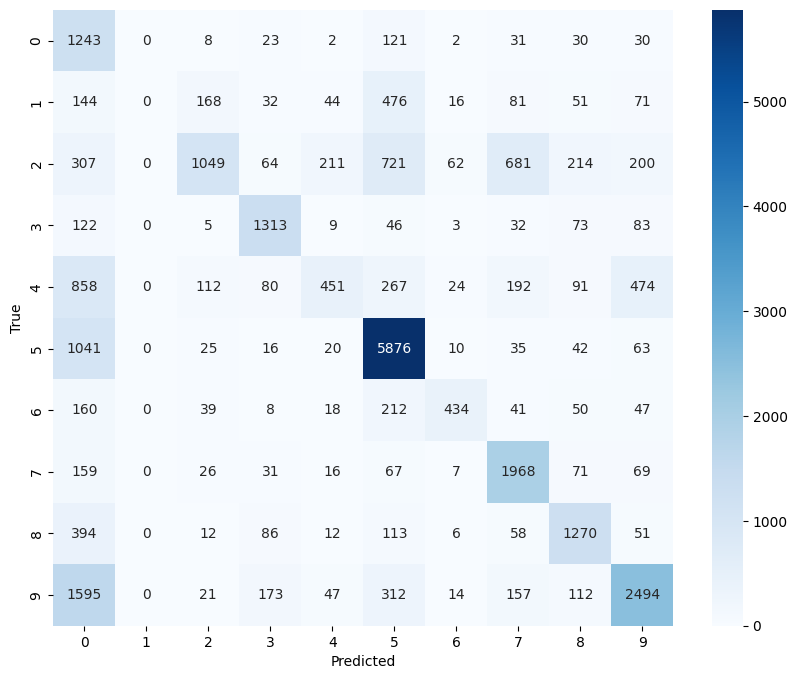

In [ ]:
# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Accuracy Score
accuracy_score = sklearn.metrics.accuracy_score(y_true, y_pred_classes)
print("accuracy_score of test set:", accuracy_score)

accuracy_score of test set: 0.579168915272531
